# Creating statistics and maps of street designations for communes

## Load libraries and data

In [3]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import time
import pysal as ps
from legendgram import legendgram
import esda

%matplotlib inline

In [4]:
%%time 

# Street name designations
streetnames = pd.read_csv('../Datapreparation/streetnames.csv', encoding='UTF-8-SIG', sep=';')

# Specific street name designations
streetnames_s = pd.read_csv('../Modeling/out_mapping.csv', encoding='UTF-8-SIG', sep=';', low_memory=False)

# Communes data
com = pd.read_csv('data/gmde_info.csv', encoding='UTF-8-SIG', sep=';')

# Communes geometries
com_geom = geopandas.read_file('data/gemeinden.geojson')

# Communes geometries only de and fr communes (it and rom removed)
com_geom_de_fr = geopandas.read_file('data/gemeinden_de_fr.geojson')

# Create dataset with all information on commune level
communes = pd.merge(com_geom, com, on=['GMDNR'], how='outer')

communes_de_fr = pd.merge(com_geom_de_fr, com, on=['GMDNR'], how='left')

CPU times: total: 4.77 s
Wall time: 6.48 s


## Mapping most common generic street term per commune

In [5]:
#get most common generic street designation per commune
commune_top_term = streetnames_s.groupby(['COM_FOSNR'])['STR_TERMS'].agg(pd.Series.mode).to_frame()

In [6]:
commune_top_term.STR_TERMS.apply(lambda x: str(x)).unique()

array(['weg', 'strasse', 'wäg', "['strasse' 'weg']", '[]', 'chemin',
       'rue', 'route', "['gasse' 'weg']", "['impasse' 'route']",
       'impasse', "['chemin' 'rue']", "['chemin' 'route']", 'gasse',
       "['steg' 'strasse']", "['steg' 'weg']", 'allee', 'platz', 'voa',
       'voia', 'veia', 'via', 'vietta', 'strada', 'ruelle',
       "['chemin' 'route' 'rue']", "['route' 'rue']",
       "['route' 'ruelle']", "['chemin' 'gasse' 'route' 'rue' 'ruelle']"],
      dtype=object)

In [7]:
#There are multiple mode for some communes, we only keep the first one.
commune_top_term['STR_TERMS'] = commune_top_term['STR_TERMS'].str.replace("(' ').*","", regex=True)

In [8]:
commune_top_term.STR_TERMS.apply(lambda x: str(x)).unique()

array(['weg', 'strasse', 'wäg', 'nan', 'chemin', 'rue', 'route',
       'impasse', 'gasse', 'allee', 'platz', 'voa', 'voia', 'veia', 'via',
       'vietta', 'strada', 'ruelle'], dtype=object)

In [161]:
streetnames_s['classif'] = streetnames_s['classif'].replace('Andere', np.NaN)

In [10]:
commune_top_term_s = streetnames_s.groupby(['COM_FOSNR'])['classif'].agg(pd.Series.mode).to_frame()

In [11]:
commune_top_term_s.classif.apply(lambda x: str(x)).unique()

array(['Natur', "['Natur' 'Siedlung']", 'Siedlung', 'Lebewesen',
       'Ortschaft', '[]',
       "['Gewässer' 'Lebewesen' 'Person' 'Religion' 'Siedlung']",
       'Person', "['Lebewesen' 'Siedlung']", "['Natur' 'Ortschaft']",
       "['Berg' 'Lebewesen']", "['Berg' 'Natur']",
       "['Natur' 'Ortschaft' 'Siedlung']",
       "['Lebewesen' 'Ortschaft' 'Person' 'Religion']",
       "['Ortschaft' 'Siedlung']", "['Ortschaft' 'Person']",
       "['Person' 'Siedlung']", "['Lebewesen' 'Natur' 'Ortschaft']",
       "['Gewässer' 'Siedlung']", "['Lebewesen' 'Natur' 'Person']",
       "['Lebewesen' 'Natur']", 'Gewässer', 'Berg',
       "['Lebewesen' 'Ortschaft' 'Siedlung']",
       "['Berg' 'Gewässer' 'Natur' 'Siedlung']",
       "['Lebewesen' 'Ortschaft' 'Person' 'Siedlung']",
       "['Ortschaft' 'Person' 'Siedlung']",
       "['Natur' 'Ortschaft' 'Person' 'Siedlung']",
       "['Ortschaft' 'Religion']", "['Berg' 'Ortschaft']",
       "['Berg' 'Natur' 'Ortschaft' 'Siedlung']",
       "['Gewäss

In [12]:
#There are multiple mode for some communes, we only keep the first one.
commune_top_term_s['classif'] = commune_top_term_s['classif'].str.replace("(' ').*","", regex=True)

In [13]:
commune_top_term_s.classif.apply(lambda x: str(x)).unique()

array(['Natur', 'nan', 'Siedlung', 'Lebewesen', 'Ortschaft', 'Person',
       'Gewässer', 'Berg', 'Religion'], dtype=object)

In [14]:
communes = pd.merge(communes, commune_top_term, left_on='GMDNR', right_on='COM_FOSNR', how='outer')
communes_de_fr = pd.merge(communes_de_fr, commune_top_term, left_on='GMDNR', right_on='COM_FOSNR', how='left')

In [15]:
communes = pd.merge(communes, commune_top_term_s, left_on='GMDNR', right_on='COM_FOSNR', how='outer')
communes_de_fr = pd.merge(communes_de_fr, commune_top_term_s, left_on='GMDNR', right_on='COM_FOSNR', how='left')

In [16]:
communes.columns

Index(['FID', 'GMDHISTID_x', 'GMDNR', 'GMDNAME_x', 'BZHISTID_x', 'BZNR_x',
       'KTNR_x', 'GRNR_x', 'AREA_HA_x', 'E_MIN', 'E_MAX', 'N_MIN', 'N_MAX',
       'E_CNTR_x', 'N_CNTR_x', 'Z_MIN', 'Z_MAX', 'Z_AVG', 'Z_MED', 'Z_CNTR_x',
       'geometry', 'GMDHISTID_y', 'GMDNAME_y', 'BZHISTID_y', 'BZNR_y',
       'KTNR_y', 'GRNR_y', 'AREA_HA_y', 'E_CNTR_y', 'N_CNTR_y', 'Z_CNTR_y',
       'GMD_STR_LENGTH', 'STR_TERMS', 'classif'],
      dtype='object')

(2468003.35, 2851257.65, 1064234.8020000015, 1306970.712999999)

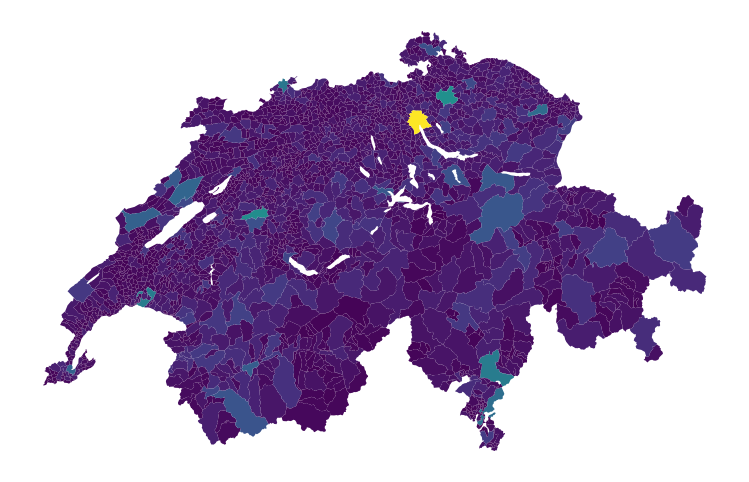

In [17]:
communes.plot(column='GMD_STR_LENGTH', figsize=(10, 6))
plt.axis('off')

In [18]:
communes['STR_TERMS'] = communes['STR_TERMS'].fillna('other')

In [19]:
communes['STR_TERMS'].apply(lambda x: str(x)).unique()

array(['strasse', 'via', 'weg', 'wäg', 'other', 'chemin', 'rue', 'route',
       'impasse', 'gasse', 'allee', 'platz', 'voa', 'voia', 'veia',
       'vietta', 'strada', 'ruelle'], dtype=object)

In [20]:
colors = {
    'allee': '#01665e',
    'chemin': '#cab2d6',
    'gasse': '#1f78b4',
    'impasse': '#e31a1c',
    'platz': '#35978f',
    'route': '#fb9a99',
    'rue': '#b2df8a',
    'ruelle': '#33a02c',
    'strada': '#ffff33',
    'strasse': '#a6cee3',
    'veia': '#f1b6da',
    'via': '#fee08b',
    'vietta': '#762a83',
    'voa': '#c51b7d',
    'voia': '#8c510a',
    'wäg': '#ff7f00',
    'weg': '#fdbf6f',
    'other': '#d9d9d9',
}


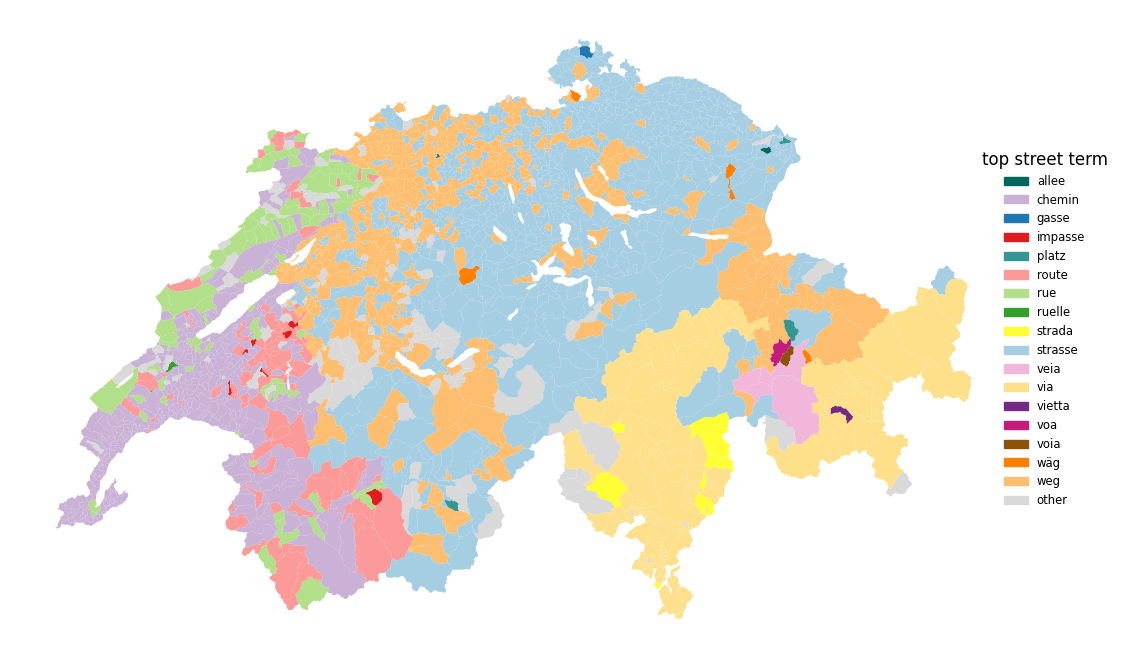

In [21]:
f, ax = plt.subplots(1, figsize=(13,13))
    
    
communes.plot(ax=ax, 
                        color=[colors[d] for d in communes.STR_TERMS])


plt.axis('off')

plt.legend(handles=[mpatches.Patch(color=colors[k],
                label=k) for k in colors],
               loc='center right',
               fontsize='small',
               edgecolor='none',
               title='top street term',
               title_fontsize='large',
               bbox_to_anchor=(1.1, 0.5))

## Mapping ratio of named streets (vs streets without name)

In [22]:
# Street name geometries
streets_geom = geopandas.read_file('data/pure_line.geojson')

In [23]:
# Create dataset with all information on street level
streetnames_geom = pd.merge(streets_geom, streetnames, on=['STR_ESID','STR_ESID'], how='outer')

In [24]:
streetnames_length_comm = streetnames_geom.dissolve(by='COM_FOSNR', aggfunc={
         "LENGTH": "sum",
         "COM_NAME": "first",
         "COM_FOSNR": "first"    
     })

In [25]:
streetnames_length_comm.columns

Index(['geometry', 'LENGTH', 'COM_NAME', 'COM_FOSNR'], dtype='object')

In [26]:
# to remove ambiguity error
streetnames_length_comm.rename(columns = {'COM_FOSNR':'FOSNR'}, inplace = True)

In [27]:
#now we have per commune street length AND streetname length
communes_length = pd.merge(communes, streetnames_length_comm, left_on='GMDNR', right_on='COM_FOSNR', how='outer')

In [28]:
communes_length.LENGTH = communes_length.LENGTH/1000

In [29]:
communes_length = communes_length.assign(ratioNamed = communes_length.LENGTH/communes_length.GMD_STR_LENGTH)

In [30]:
# to remove ambiguity error
communes_length.rename(columns = {'geometry_x':'geometry'}, inplace = True)

In [31]:
communes_length['ratioNamed'] = communes_length['ratioNamed'].fillna('0')

In [32]:
communes_length['ratioNamed'] = communes_length['ratioNamed'].astype(str).astype(float)

Text(0.5, 1.0, 'Verhältnis benannte vs. unbenannte Strassen')

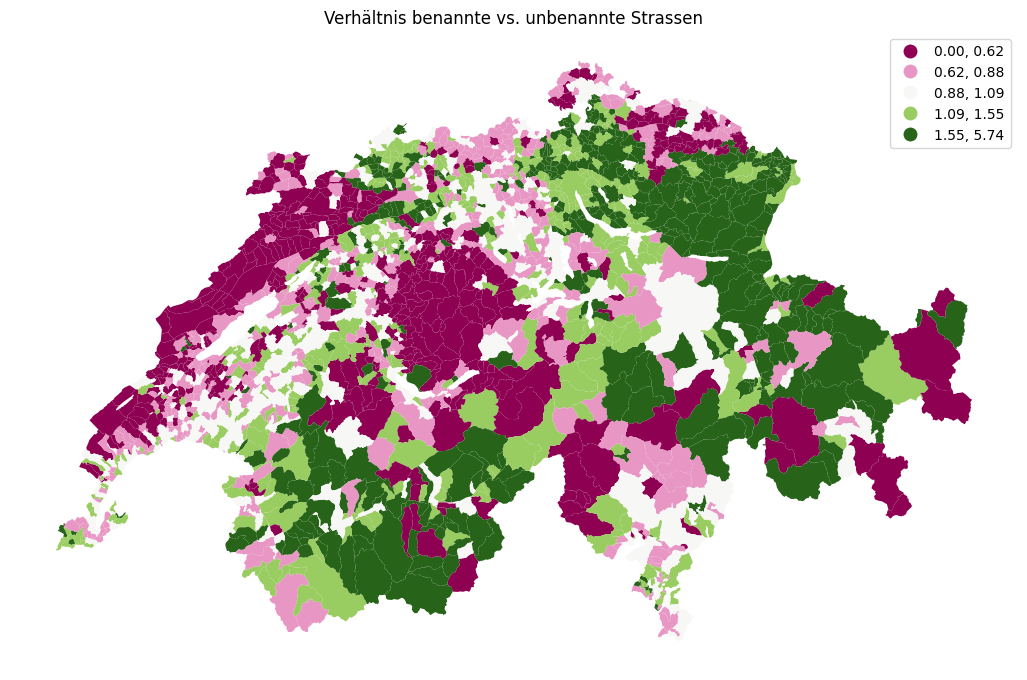

In [33]:
f, ax = plt.subplots(1, figsize=(13,13))
    
    
communes_length.plot(column='ratioNamed', 
                     cmap='PiYG', 
                     figsize=(10, 6), 
                     ax=ax, 
                     legend=True,
                     scheme='quantiles')

plt.axis('off')
plt.title("Verhältnis benannte vs. unbenannte Strassen")

# Mapping most common specific street term per commune

In [34]:
communes_de_fr['classif'] = communes_de_fr['classif'].fillna('no_value')

In [35]:
communes_de_fr['classif'].apply(lambda x: str(x)).unique()

array(['Natur', 'no_value', 'Siedlung', 'Lebewesen', 'Ortschaft',
       'Person', 'Gewässer', 'Berg'], dtype=object)

In [36]:
colors = {
    'Ortschaft': '#e41a1c',
    'Natur': '#4daf4a',
    'Gewässer': '#1f78b4',
    'Lebewesen': '#984ea3',
    'Siedlung': '#ff7f00',
    'Person': '#ffff33',
    'Berg': '#a65628',
    'Religion': '#f781bf',
    #'Andere' : '#fee08b',
    'no_value': '#d9d9d9',
}

In [481]:
communes_de_fr

FID  GMDHISTID_x  GMDNR           GMDNAME_x  BZHISTID_x  BZNR_x  \
0        0        16620   3112       Schwende-Rüte       10252    1600   
1        2        13256      1     Aeugst am Albis       10053     101   
2        3        11742      2  Affoltern am Albis       10053     101   
3        4        11801      3          Bonstetten       10053     101   
4        5        11992      4     Hausen am Albis       10053     101   
...    ...          ...    ...                 ...         ...     ...   
1992  2143        13353   6806        Vendlincourt       10226    2603   
1993  2144        14970   6807       Basse-Allaine       10226    2603   
1994  2145        14965   6808       Clos du Doubs       10226    2603   
1995  2146        16120   6809         Haute-Ajoie       10226    2603   
1996  2147        14969   6810          La Baroche       10226    2603   

      KTNR_x  GRNR_x  AREA_HA_x    E_MIN  ...  BZNR_y  KTNR_y  GRNR_y  \
0         16       5       9833  2742569  ...    1600      16       5   
1          1       4        791  2678111  ...     101       1       4   
2          1       4       1059  2673826  ...     101       1       4   
3          1       4        743  2675745  ...     101       1       4   
4          1       4       1360  2680394  ...     101       1       4   
...      ...     ...        ...      ...  ...     ...     ...     ...   
1992      26       2        915  2575722  ...    2603      26       2   
1993      26       2       2304  2566914  ...    2603      26       2   
1994      26       2       6175  2569448  ...    2603      26       2   
1995      26       2       4093  2557722  ...    2603      26       2   
1996      26       2       3107  2578224  ...    2603      26       2   

      AREA_HA_y  E_CNTR_y  N_CNTR_y  Z_CNTR_y  GMD_STR_LENGTH  STR_TERMS  \
0          9833   2750500   1243000       799      108.036588    strasse   
1           791   2679300   1235700       700       26.516156        weg   
2          1059   2676800   1236800       490       66.711839    strasse   
3           743   2677800   1241000       544       31.501571    strasse   
4          1360   2682900   1233100       610       42.495957    strasse   
...         ...       ...       ...       ...             ...        ...   
1992        915   2578200   1255600       441       19.431732      route   
1993       2304   2569300   1258900       385       46.657442      route   
1994       6175   2579100   1246300       449      101.283739     chemin   
1995       4093   2567000   1249100       492       64.072282        rue   
1996       3107   2582400   1252500       523       43.076611     chemin   

        classif  
0         Natur  
1         Natur  
2         Natur  
3         Natur  
4         Natur  
...         ...  
1992   no_value  
1993  Ortschaft  
1994     Person  
1995  Ortschaft  
1996  Ortschaft  

[1997 rows x 35 columns]

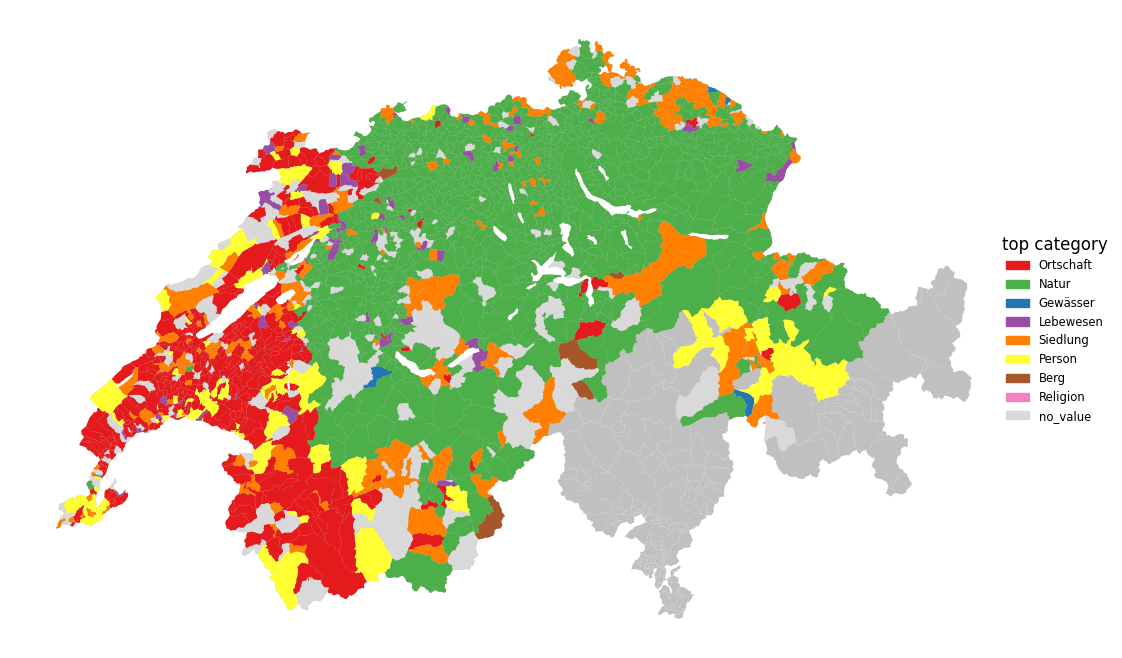

In [483]:
f, ax = plt.subplots(1, figsize=(13,13))
    
communes.plot(figsize=(13,13),ax=ax, color = 'silver')
communes_de_fr.plot(ax=ax, 
                        color=[colors[d] for d in communes_de_fr.classif])


plt.axis('off')

plt.legend(handles=[mpatches.Patch(color=colors[k],
                label=k) for k in colors],
               loc='center right',
               fontsize='small',
               edgecolor='none',
               title='top category',
               title_fontsize='large',
               bbox_to_anchor=(1.1, 0.5))



## Mapping percent of common specific street term per commune

In [38]:
streetnames_s.groupby(['COM_FOSNR', 'classif']).size().to_frame()

0
COM_FOSNR classif      
1.0       Berg        7
          Gewässer    3
          Lebewesen   1
          Natur      15
          Ortschaft   6
...                  ..
6810.0    Lebewesen   2
          Ortschaft  16
          Person      4
          Religion    1
          Siedlung   11

[13927 rows x 1 columns]

In [16]:
kategorie = 'Person'

subset = streetnames_s['classif'].str.contains(kategorie).groupby(streetnames_s['COM_FOSNR']).sum().to_frame()
subset["classif"] = subset["classif"].astype(int)

In [17]:
alle = streetnames_s.groupby(['COM_FOSNR'])['classif'].agg(pd.Series.count).to_frame()

In [18]:
kategorie_merge = pd.merge(subset, alle, on='COM_FOSNR', how='outer')

In [19]:
kategorie_merge = kategorie_merge.assign(percent_subset = kategorie_merge.classif_x/kategorie_merge.classif_y*100)
kategorie_merge

classif_x  classif_y  percent_subset
COM_FOSNR                                      
1.0                2         75        2.666667
2.0                5        197        2.538071
3.0                9        139        6.474820
4.0                8        157        5.095541
5.0                6        178        3.370787
...              ...        ...             ...
6806.0             4         27       14.814815
6807.0             6         53       11.320755
6808.0            11         60       18.333333
6809.0             6         62        9.677419
6810.0             4         81        4.938272

[2082 rows x 3 columns]

In [20]:
communes_kategorie = pd.merge(communes, kategorie_merge, left_on='GMDNR', right_on='COM_FOSNR', how='outer')
communes_kategorie = communes_kategorie.fillna(0)

In [21]:
import mapclassify as mc
bins = mc.Quantiles(communes_kategorie['percent_subset'].values, k=9).bins
bins

array([ 0.        ,  1.63934426,  2.93300654,  4.16666667,  5.47138047,
        7.05128205,  9.55077006, 14.28571429, 50.        ])

Text(0.5, 0, '% Kategorie: Person')

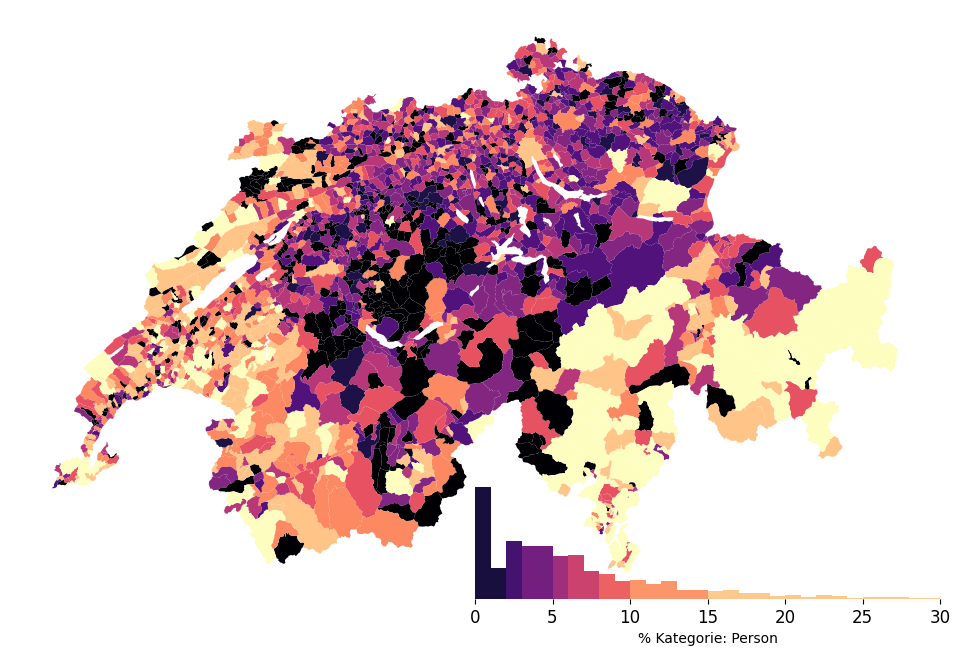

In [22]:
import palettable.matplotlib as palmpl
import mapclassify as mc

f,ax = plt.subplots(1, figsize=(12,12))
communes_kategorie.plot('percent_subset', k=9, ax=ax, cmap='magma', scheme='Quantiles')

bins = mc.Quantiles(communes_kategorie['percent_subset'].values, k=9).bins
ax.axis('off')

legendgram(f,ax,communes_kategorie['percent_subset'],bins,pal=palmpl.Magma_9,
           legend_size=(.5,.2), # legend size in fractions of the axis
           loc='lower right', # matplotlib-style legend locations
           clip = (0,30) # clip the displayed range of the histogram
           )


xlabel = '% Kategorie: ' + kategorie
plt.xlabel(xlabel)

Text(0.5, 0, '% Kategorie: Person')

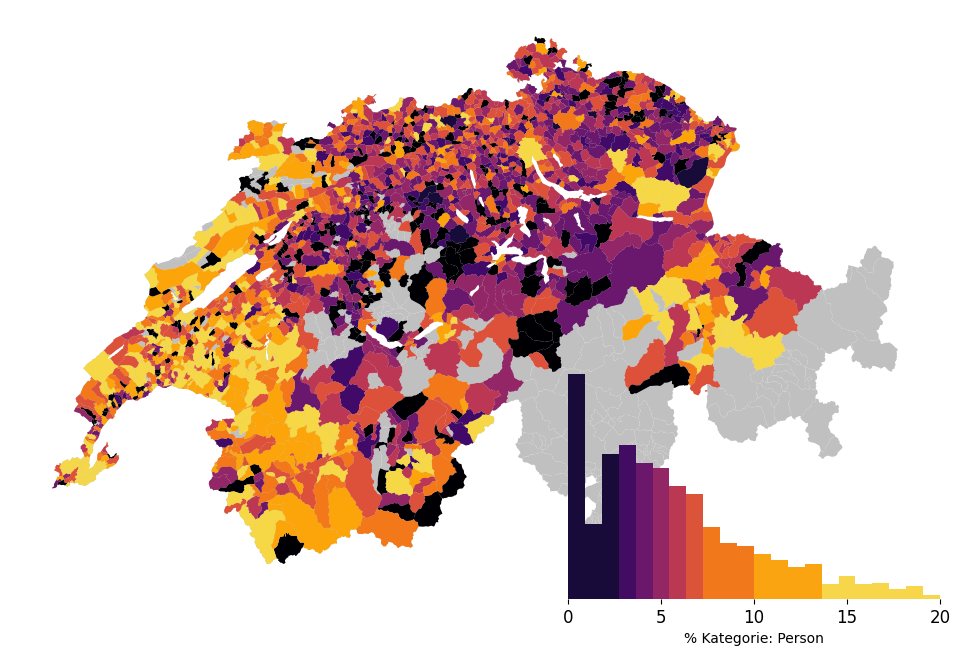

In [383]:
kategorie = 'Person'

streetnames_s = pd.read_csv('../Modeling/out_mapping.csv', encoding='UTF-8-SIG', sep=';', low_memory=False)
subset = streetnames_s['classif'].str.contains(kategorie).groupby(streetnames_s['COM_FOSNR']).sum().to_frame()
subset["classif"] = subset["classif"].astype(int)

alle = streetnames_s.groupby(['COM_FOSNR'])['classif'].agg(pd.Series.count).to_frame()

kategorie_merge = pd.merge(subset, alle, on='COM_FOSNR', how='outer')

kategorie_merge = kategorie_merge.assign(percent_subset = kategorie_merge.classif_x/kategorie_merge.classif_y*100)

communes_kategorie = pd.merge(communes_de_fr, kategorie_merge, left_on='GMDNR', right_on='COM_FOSNR', how='left')
communes_kategorie = communes_kategorie.fillna(0)
communes_kategorie = communes_kategorie[communes_kategorie.classif_y > 10]

import palettable.matplotlib as palmpl
import mapclassify as mc

k=10
bins = mc.Quantiles(communes_kategorie['percent_subset'].values, k=k).bins
bins = bins.astype(int).tolist()
bins = dict(bins=bins)
bins

f,ax = plt.subplots(1, figsize=(12,12))
communes.plot(figsize=(12,12),ax=ax, color = 'silver')
communes_kategorie.plot('percent_subset', k=k, ax=ax, cmap='inferno', scheme="User_Defined",
                             classification_kwds=bins)

bins = mc.Quantiles(communes_kategorie['percent_subset'].values, k=k).bins
ax.axis('off')

legendgram(f,ax,communes_kategorie['percent_subset'],bins,pal=palmpl.Inferno_10,
           legend_size=(.4,.4), # legend size in fractions of the axis
           loc='lower right', # matplotlib-style legend locations
           clip = (0,20) # clip the displayed range of the histogram
           )

xlabel = '% Kategorie: ' + kategorie
plt.xlabel(xlabel)

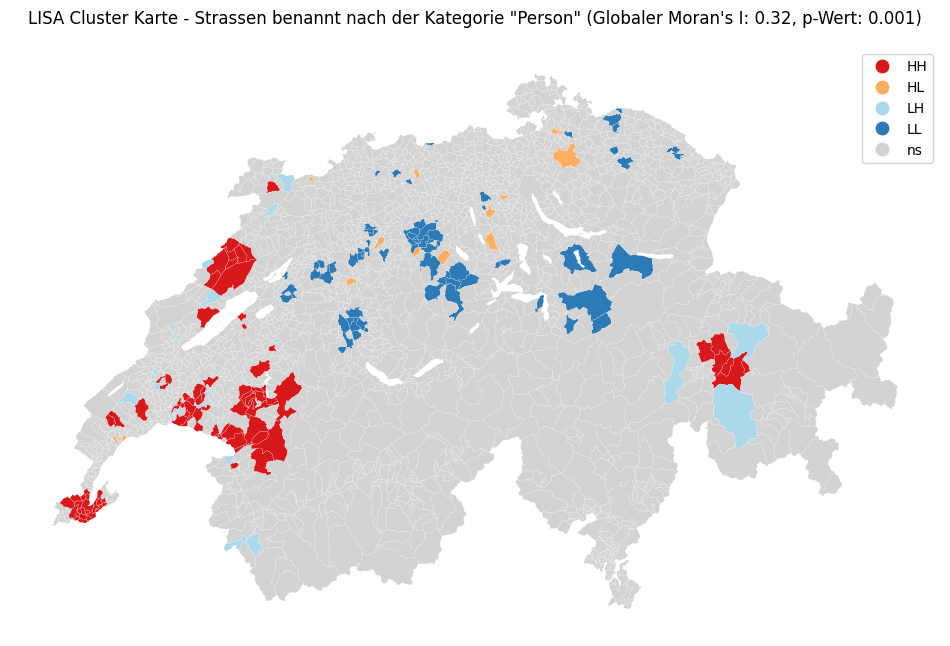

In [384]:
from splot.esda import lisa_cluster
from libpysal.weights.contiguity import Queen
from esda.moran import Moran_Local, Moran


trans = communes_kategorie.drop(columns=['geometry'])
gdf = pd.merge(com_geom, trans, on=['GMDNR'], how='outer')
gdf['percent_subset'].fillna(value=gdf['percent_subset'].median(), inplace = True)

#gdf = gdf[gdf.classif_y > 10]


#gdf.loc[gdf['classif_y'] < 10, 'percent_subset'] = gdf['percent_subset'].mean()

#gdf = communes_kategorie
w = Queen.from_dataframe(gdf)
y = gdf['percent_subset'].values
moran = Moran(y, w)

moran_loc = Moran_Local(y, w)
lisa_cluster(moran_loc, gdf, p=0.01, figsize = (12,12))
string = "LISA Cluster Karte - Strassen benannt nach der Kategorie \"" + str(kategorie) +'\" (Globaler Moran\'s I: ' + str(round(moran.I,2)) + ', p-Wert: '+ str(round(moran.p_sim,5)) + ')'
plt.title(string)
plt.show()

In [301]:
print(gdf[gdf['GMDNAME'].str.contains('Entlebuch')])



     FID_x  GMDHISTID  GMDNR    GMDNAME  BZHISTID  BZNR  KTNR  GRNR  AREA_HA  \
503    503      15561   1002  Entlebuch     10303   316     3     6     5690   

     E_MIN_x  ...  AREA_HA_y   E_CNTR_y   N_CNTR_y  Z_CNTR_y  GMD_STR_LENGTH  \
503  2643451  ...     5690.0  2647600.0  1204800.0     722.0       96.967789   

     STR_TERMS  classif  classif_x  classif_y  percent_subset  
503    strasse    Natur        0.0       49.0             0.0  

[1 rows x 57 columns]


Text(0.5, 0, '% Kategorie: Siedlung')

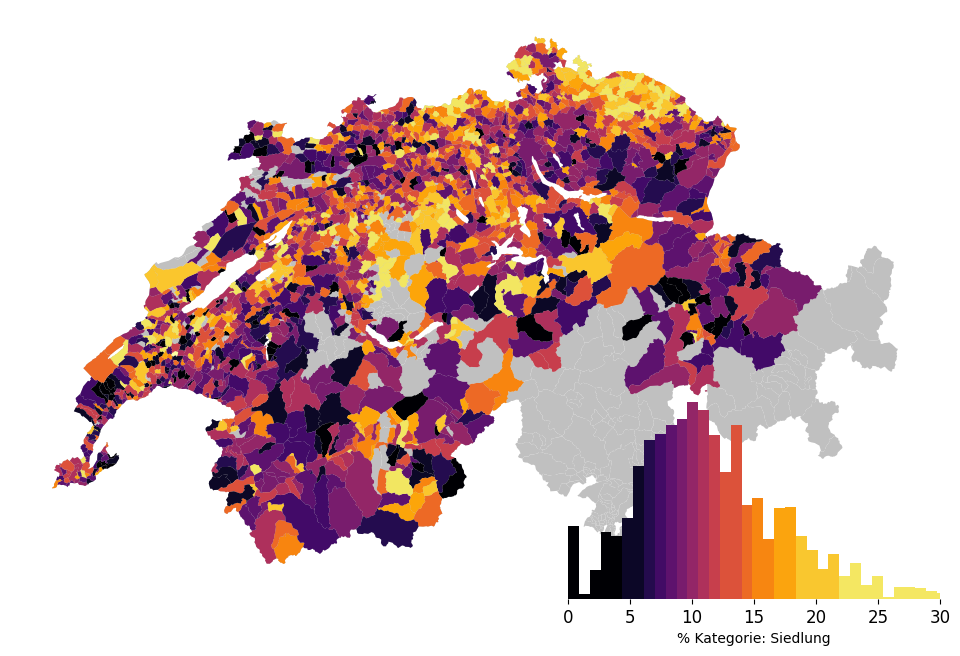

In [379]:
kategorie = 'Siedlung'

streetnames_s = pd.read_csv('../Modeling/out_mapping.csv', encoding='UTF-8-SIG', sep=';', low_memory=False)
subset = streetnames_s['classif'].str.contains(kategorie).groupby(streetnames_s['COM_FOSNR']).sum().to_frame()
subset["classif"] = subset["classif"].astype(int)

alle = streetnames_s.groupby(['COM_FOSNR'])['classif'].agg(pd.Series.count).to_frame()

kategorie_merge = pd.merge(subset, alle, on='COM_FOSNR', how='outer')

kategorie_merge = kategorie_merge.assign(percent_subset = kategorie_merge.classif_x/kategorie_merge.classif_y*100)

communes_kategorie = pd.merge(communes_de_fr, kategorie_merge, left_on='GMDNR', right_on='COM_FOSNR', how='left')
communes_kategorie = communes_kategorie.fillna(0)
communes_kategorie = communes_kategorie[communes_kategorie.classif_y > 10]

import palettable.matplotlib as palmpl
import mapclassify as mc

k=15
bins = mc.Quantiles(communes_kategorie['percent_subset'].values, k=k).bins
bins = bins.astype(int).tolist()
bins = dict(bins=bins)
bins

f,ax = plt.subplots(1, figsize=(12,12))
communes.plot(figsize=(12,12),ax=ax, color = 'silver')
communes_kategorie.plot('percent_subset', k=k, ax=ax, cmap='inferno', scheme="User_Defined",
                             classification_kwds=bins)

bins = mc.Quantiles(communes_kategorie['percent_subset'].values, k=k).bins
ax.axis('off')

legendgram(f,ax,communes_kategorie['percent_subset'],bins,pal=palmpl.Inferno_15,
           legend_size=(.4,.35), # legend size in fractions of the axis
           loc='lower right', # matplotlib-style legend locations
           clip = (0,30) # clip the displayed range of the histogram
           )

xlabel = '% Kategorie: ' + kategorie
plt.xlabel(xlabel)

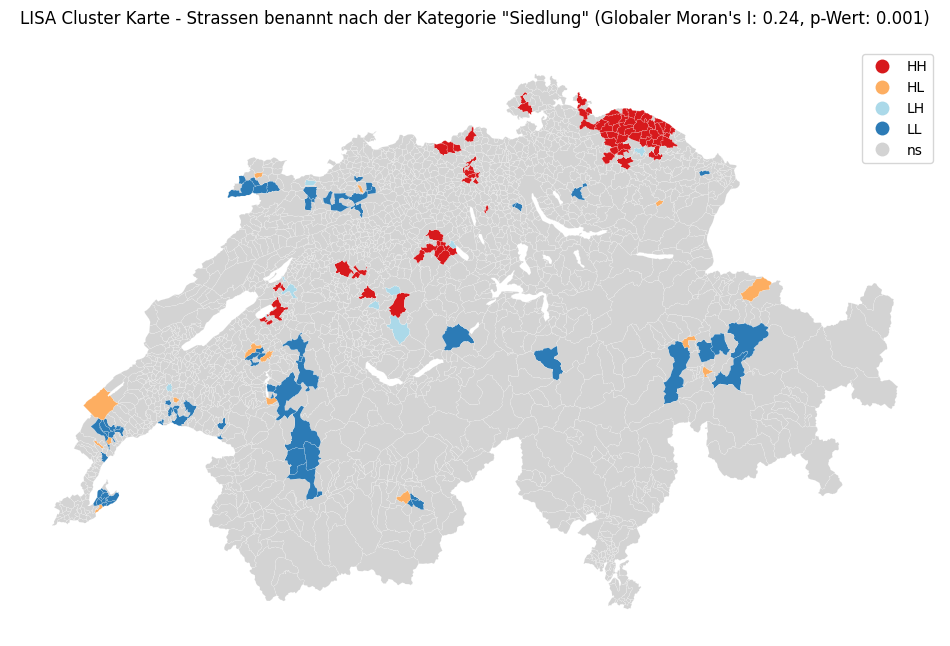

In [382]:
from splot.esda import lisa_cluster
from libpysal.weights.contiguity import Queen
from esda.moran import Moran_Local, Moran


trans = communes_kategorie.drop(columns=['geometry'])
gdf = pd.merge(com_geom, trans, on=['GMDNR'], how='outer')
gdf['percent_subset'].fillna(value=gdf['percent_subset'].median(), inplace = True)

#gdf = gdf[gdf.classif_y > 10]


#gdf.loc[gdf['classif_y'] < 10, 'percent_subset'] = gdf['percent_subset'].mean()

#gdf = communes_kategorie
w = Queen.from_dataframe(gdf)
y = gdf['percent_subset'].values
moran = Moran(y, w)

moran_loc = Moran_Local(y, w)
lisa_cluster(moran_loc, gdf, p=0.01, figsize = (12,12))
string = "LISA Cluster Karte - Strassen benannt nach der Kategorie \"" + str(kategorie) +'\" (Globaler Moran\'s I: ' + str(round(moran.I,2)) + ', p-Wert: '+ str(round(moran.p_sim,5)) + ')'
plt.title(string)
plt.show()

Text(0.5, 0, '% Kategorie: Ortschaft')

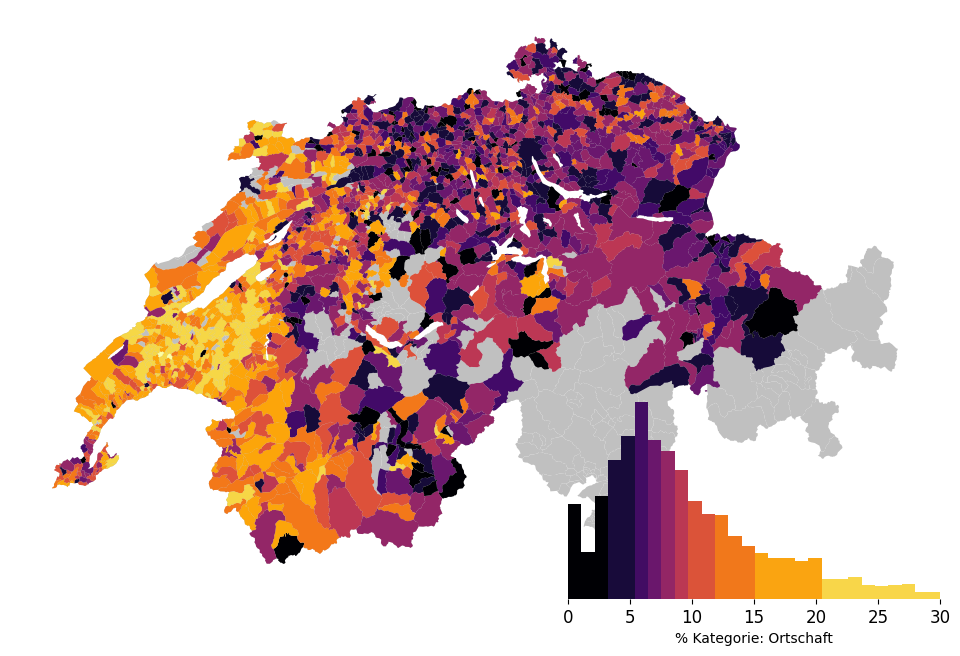

In [377]:
kategorie = 'Ortschaft'

streetnames_s = pd.read_csv('../Modeling/out_mapping.csv', encoding='UTF-8-SIG', sep=';', low_memory=False)
subset = streetnames_s['classif'].str.contains(kategorie).groupby(streetnames_s['COM_FOSNR']).sum().to_frame()
subset["classif"] = subset["classif"].astype(int)

alle = streetnames_s.groupby(['COM_FOSNR'])['classif'].agg(pd.Series.count).to_frame()

kategorie_merge = pd.merge(subset, alle, on='COM_FOSNR', how='outer')

kategorie_merge = kategorie_merge.assign(percent_subset = kategorie_merge.classif_x/kategorie_merge.classif_y*100)

communes_kategorie = pd.merge(communes_de_fr, kategorie_merge, left_on='GMDNR', right_on='COM_FOSNR', how='left')
communes_kategorie = communes_kategorie.fillna(0)
communes_kategorie = communes_kategorie[communes_kategorie.classif_y > 10]

import palettable.matplotlib as palmpl
import mapclassify as mc

k=10
bins = mc.Quantiles(communes_kategorie['percent_subset'].values, k=k).bins
bins = bins.astype(int).tolist()
bins = dict(bins=bins)
bins

f,ax = plt.subplots(1, figsize=(12,12))
communes.plot(figsize=(12,12),ax=ax, color = 'silver')
communes_kategorie.plot('percent_subset', k=k, ax=ax, cmap='inferno', scheme="User_Defined",
                             classification_kwds=bins)

bins = mc.Quantiles(communes_kategorie['percent_subset'].values, k=k).bins
ax.axis('off')

legendgram(f,ax,communes_kategorie['percent_subset'],bins,pal=palmpl.Inferno_10,
           legend_size=(.4,.35), # legend size in fractions of the axis
           loc='lower right', # matplotlib-style legend locations
           clip = (0,30) # clip the displayed range of the histogram
           )

xlabel = '% Kategorie: ' + kategorie
plt.xlabel(xlabel)

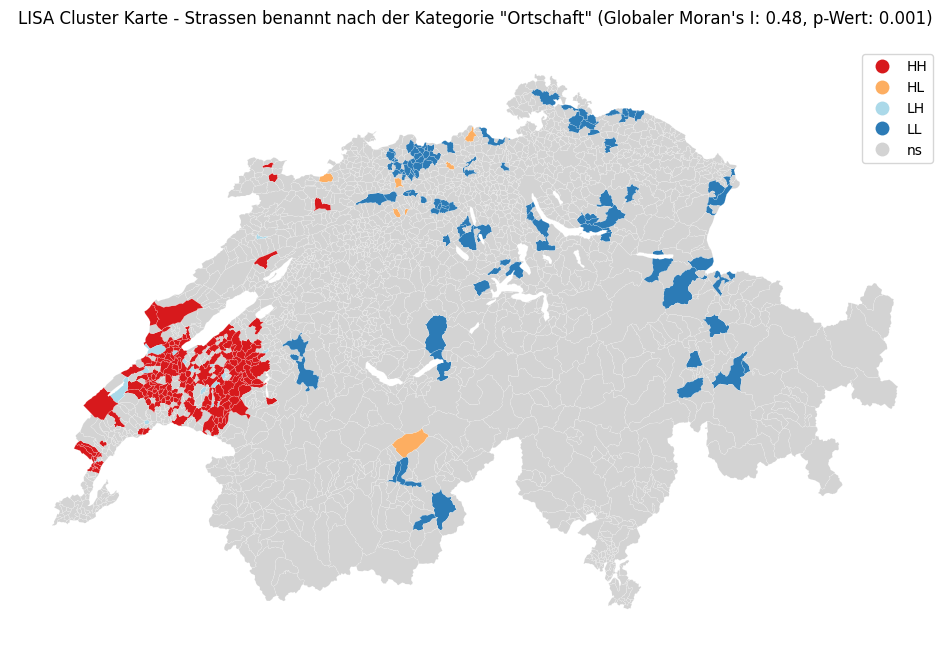

In [378]:
from splot.esda import lisa_cluster
from libpysal.weights.contiguity import Queen
from esda.moran import Moran_Local, Moran


trans = communes_kategorie.drop(columns=['geometry'])
gdf = pd.merge(com_geom, trans, on=['GMDNR'], how='outer')
gdf['percent_subset'].fillna(value=gdf['percent_subset'].median(), inplace = True)

#gdf = gdf[gdf.classif_y > 10]


#gdf.loc[gdf['classif_y'] < 10, 'percent_subset'] = gdf['percent_subset'].mean()

#gdf = communes_kategorie
w = Queen.from_dataframe(gdf)
y = gdf['percent_subset'].values
moran = Moran(y, w)

moran_loc = Moran_Local(y, w)
lisa_cluster(moran_loc, gdf, p=0.01, figsize = (12,12))
string = "LISA Cluster Karte - Strassen benannt nach der Kategorie \"" + str(kategorie) +'\" (Globaler Moran\'s I: ' + str(round(moran.I,2)) + ', p-Wert: '+ str(round(moran.p_sim,5)) + ')'
plt.title(string)
plt.show()

Text(0.5, 0, '% Kategorie: Gewässer')

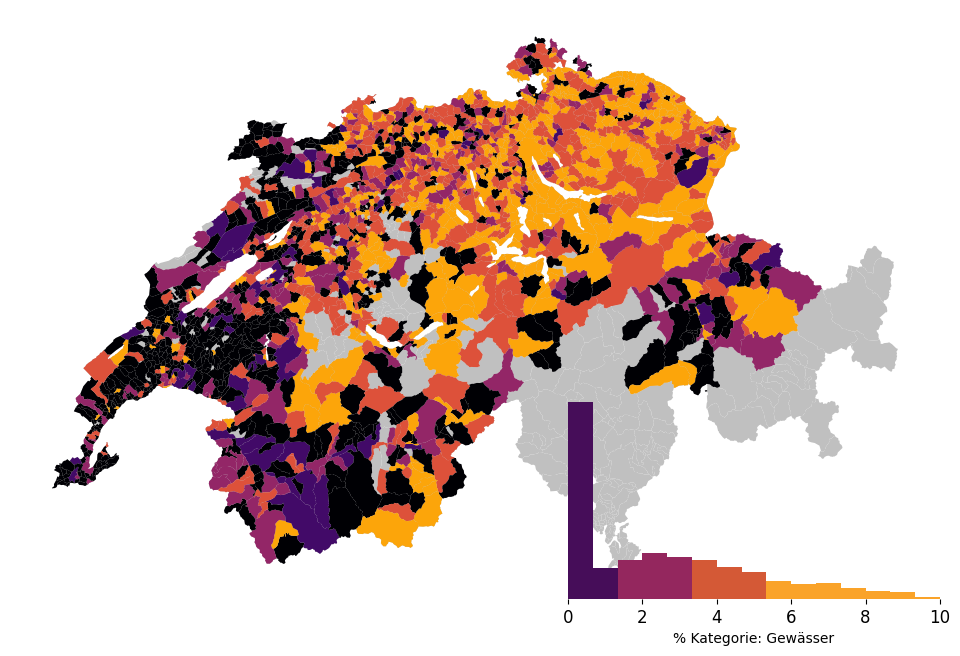

In [393]:
kategorie = 'Gewässer'

streetnames_s = pd.read_csv('../Modeling/out_mapping.csv', encoding='UTF-8-SIG', sep=';', low_memory=False)
subset = streetnames_s['classif'].str.contains(kategorie).groupby(streetnames_s['COM_FOSNR']).sum().to_frame()
subset["classif"] = subset["classif"].astype(int)

alle = streetnames_s.groupby(['COM_FOSNR'])['classif'].agg(pd.Series.count).to_frame()

kategorie_merge = pd.merge(subset, alle, on='COM_FOSNR', how='outer')

kategorie_merge = kategorie_merge.assign(percent_subset = kategorie_merge.classif_x/kategorie_merge.classif_y*100)

communes_kategorie = pd.merge(communes_de_fr, kategorie_merge, left_on='GMDNR', right_on='COM_FOSNR', how='left')
communes_kategorie = communes_kategorie.fillna(0)
communes_kategorie = communes_kategorie[communes_kategorie.classif_y > 10]

import palettable.matplotlib as palmpl
import mapclassify as mc

k=5
bins = mc.Quantiles(communes_kategorie['percent_subset'].values, k=k).bins
bins = bins.astype(int).tolist()
bins = dict(bins=bins)
bins

f,ax = plt.subplots(1, figsize=(12,12))
communes.plot(figsize=(12,12),ax=ax, color = 'silver')
communes_kategorie.plot('percent_subset', k=k, ax=ax, cmap='inferno', scheme="User_Defined",
                             classification_kwds=bins)

bins = mc.Quantiles(communes_kategorie['percent_subset'].values, k=k).bins
ax.axis('off')

legendgram(f,ax,communes_kategorie['percent_subset'],bins,pal=palmpl.Inferno_5,
           legend_size=(.4,.35), # legend size in fractions of the axis
           loc='lower right', # matplotlib-style legend locations
           clip = (0,10) # clip the displayed range of the histogram
           )

xlabel = '% Kategorie: ' + kategorie
plt.xlabel(xlabel)

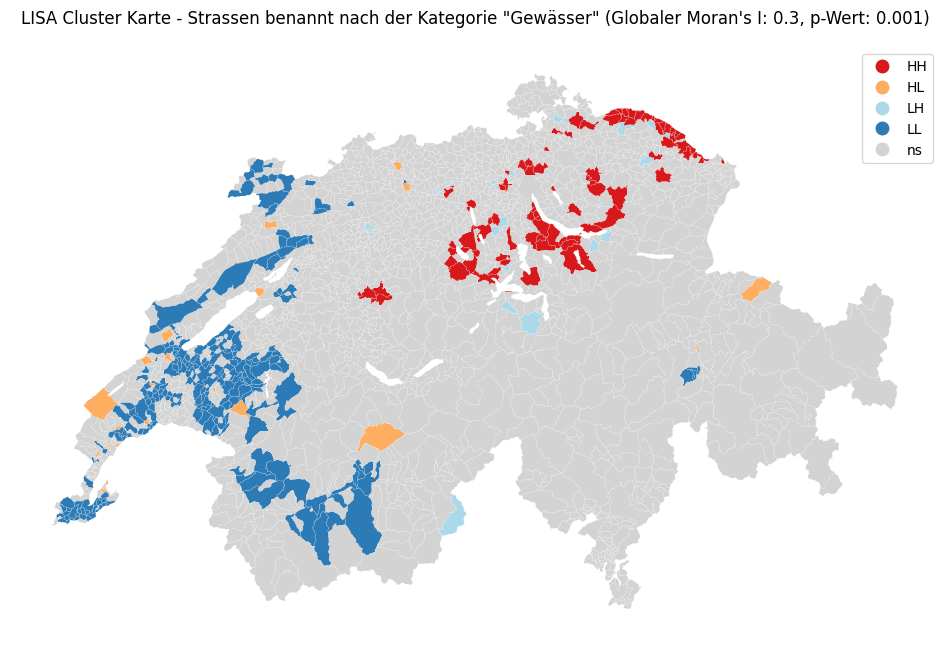

In [398]:
from splot.esda import lisa_cluster
from libpysal.weights.contiguity import Queen
from esda.moran import Moran_Local, Moran


trans = communes_kategorie.drop(columns=['geometry'])
gdf = pd.merge(com_geom, trans, on=['GMDNR'], how='outer')
gdf['percent_subset'].fillna(value=gdf['percent_subset'].median(), inplace = True)

#gdf = gdf[gdf.classif_y > 10]


#gdf.loc[gdf['classif_y'] < 10, 'percent_subset'] = gdf['percent_subset'].mean()

#gdf = communes_kategorie
w = Queen.from_dataframe(gdf)
y = gdf['percent_subset'].values
moran = Moran(y, w)

moran_loc = Moran_Local(y, w)
lisa_cluster(moran_loc, gdf, p=0.02, figsize = (12,12))
string = "LISA Cluster Karte - Strassen benannt nach der Kategorie \"" + str(kategorie) +'\" (Globaler Moran\'s I: ' + str(round(moran.I,2)) + ', p-Wert: '+ str(round(moran.p_sim,5)) + ')'
plt.title(string)
plt.show()

Text(0.5, 0, '% Kategorie: Berg')

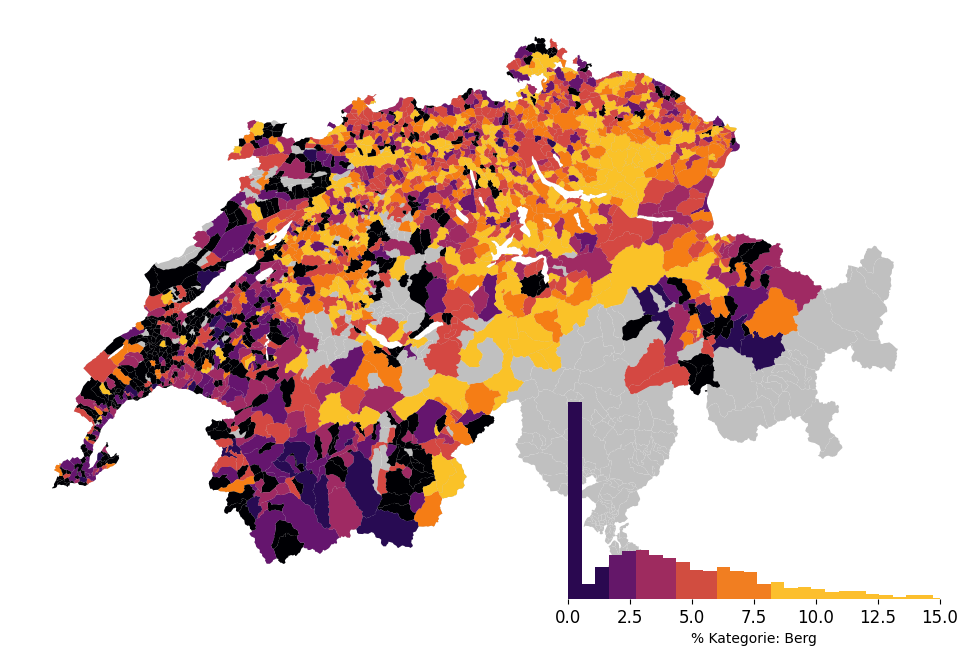

In [399]:
kategorie = 'Berg'

streetnames_s = pd.read_csv('../Modeling/out_mapping.csv', encoding='UTF-8-SIG', sep=';', low_memory=False)
subset = streetnames_s['classif'].str.contains(kategorie).groupby(streetnames_s['COM_FOSNR']).sum().to_frame()
subset["classif"] = subset["classif"].astype(int)

alle = streetnames_s.groupby(['COM_FOSNR'])['classif'].agg(pd.Series.count).to_frame()

kategorie_merge = pd.merge(subset, alle, on='COM_FOSNR', how='outer')

kategorie_merge = kategorie_merge.assign(percent_subset = kategorie_merge.classif_x/kategorie_merge.classif_y*100)

communes_kategorie = pd.merge(communes_de_fr, kategorie_merge, left_on='GMDNR', right_on='COM_FOSNR', how='left')
communes_kategorie = communes_kategorie.fillna(0)
communes_kategorie = communes_kategorie[communes_kategorie.classif_y > 10]

import palettable.matplotlib as palmpl
import mapclassify as mc

k=7
bins = mc.Quantiles(communes_kategorie['percent_subset'].values, k=k).bins
bins = bins.astype(int).tolist()
bins = dict(bins=bins)
bins

f,ax = plt.subplots(1, figsize=(12,12))
communes.plot(figsize=(12,12),ax=ax, color = 'silver')
communes_kategorie.plot('percent_subset', k=k, ax=ax, cmap='inferno', scheme="User_Defined",
                             classification_kwds=bins)

bins = mc.Quantiles(communes_kategorie['percent_subset'].values, k=k).bins
ax.axis('off')

legendgram(f,ax,communes_kategorie['percent_subset'],bins,pal=palmpl.Inferno_7,
           legend_size=(.4,.35), # legend size in fractions of the axis
           loc='lower right', # matplotlib-style legend locations
           clip = (0,15) # clip the displayed range of the histogram
           )

xlabel = '% Kategorie: ' + kategorie
plt.xlabel(xlabel)

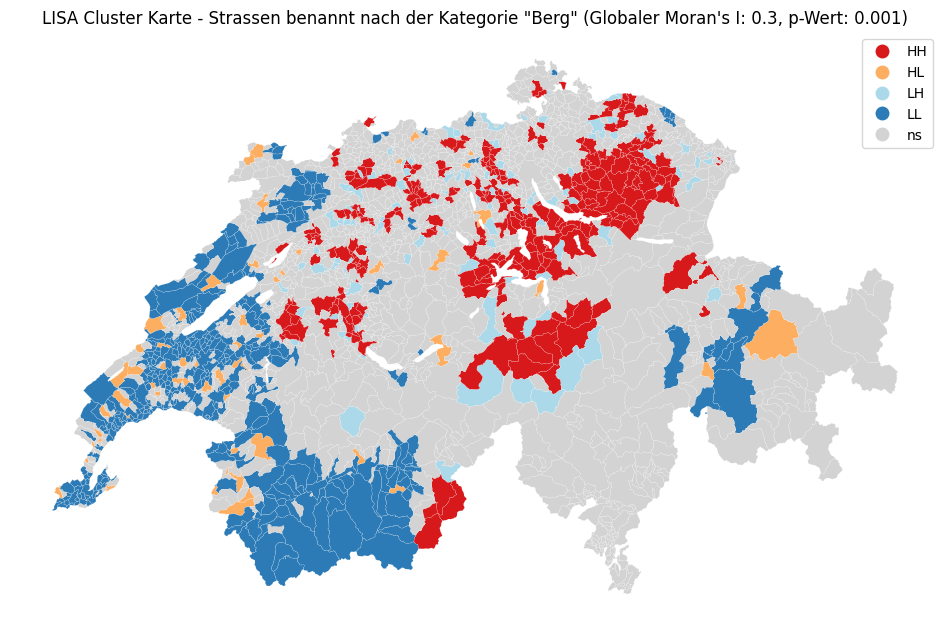

In [407]:
from splot.esda import lisa_cluster
from libpysal.weights.contiguity import Queen
from esda.moran import Moran_Local, Moran


trans = communes_kategorie.drop(columns=['geometry'])
gdf = pd.merge(com_geom, trans, on=['GMDNR'], how='outer')
gdf['percent_subset'].fillna(value=gdf['percent_subset'].median(), inplace = True)

#gdf = gdf[gdf.classif_y > 10]


#gdf.loc[gdf['classif_y'] < 10, 'percent_subset'] = gdf['percent_subset'].mean()

#gdf = communes_kategorie
w = Queen.from_dataframe(gdf)
y = gdf['percent_subset'].values
moran = Moran(y, w)

moran_loc = Moran_Local(y, w)
lisa_cluster(moran_loc, gdf, p=0.05, figsize = (12,12))
string = "LISA Cluster Karte - Strassen benannt nach der Kategorie \"" + str(kategorie) +'\" (Globaler Moran\'s I: ' + str(round(moran.I,2)) + ', p-Wert: '+ str(round(moran.p_sim,5)) + ')'
plt.title(string)
plt.show()

Text(0.5, 0, '% Kategorie: Religion')

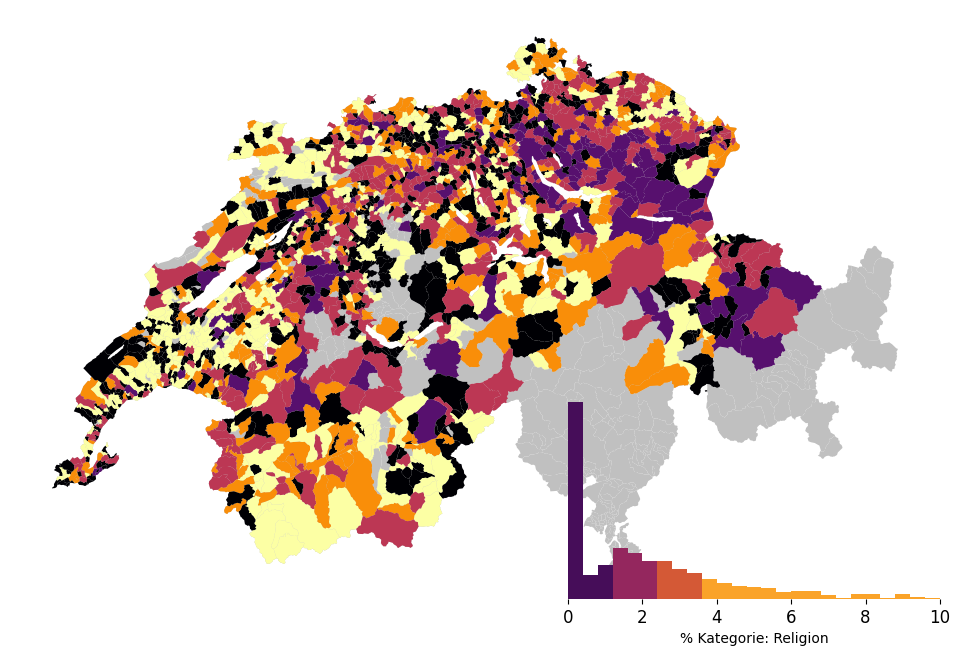

In [418]:
kategorie = 'Religion'

streetnames_s = pd.read_csv('../Modeling/out_mapping.csv', encoding='UTF-8-SIG', sep=';', low_memory=False)
subset = streetnames_s['classif'].str.contains(kategorie).groupby(streetnames_s['COM_FOSNR']).sum().to_frame()
subset["classif"] = subset["classif"].astype(int)

alle = streetnames_s.groupby(['COM_FOSNR'])['classif'].agg(pd.Series.count).to_frame()

kategorie_merge = pd.merge(subset, alle, on='COM_FOSNR', how='outer')

kategorie_merge = kategorie_merge.assign(percent_subset = kategorie_merge.classif_x/kategorie_merge.classif_y*100)

communes_kategorie = pd.merge(communes_de_fr, kategorie_merge, left_on='GMDNR', right_on='COM_FOSNR', how='left')
communes_kategorie = communes_kategorie.fillna(0)
communes_kategorie = communes_kategorie[communes_kategorie.classif_y > 10]

import palettable.matplotlib as palmpl
import mapclassify as mc

k=5
bins = mc.Quantiles(communes_kategorie['percent_subset'].values, k=k).bins
bins = bins.astype(int).tolist()
bins = dict(bins=bins)
bins

f,ax = plt.subplots(1, figsize=(12,12))
communes.plot(figsize=(12,12),ax=ax, color = 'silver')
communes_kategorie.plot('percent_subset', k=k, ax=ax, cmap='inferno', scheme="User_Defined",
                             classification_kwds=bins)

bins = mc.Quantiles(communes_kategorie['percent_subset'].values, k=k).bins
ax.axis('off')

legendgram(f,ax,communes_kategorie['percent_subset'],bins,pal=palmpl.Inferno_5,
           legend_size=(.4,.35), # legend size in fractions of the axis
           loc='lower right', # matplotlib-style legend locations
           clip = (0,10) # clip the displayed range of the histogram
           )

xlabel = '% Kategorie: ' + kategorie
plt.xlabel(xlabel)

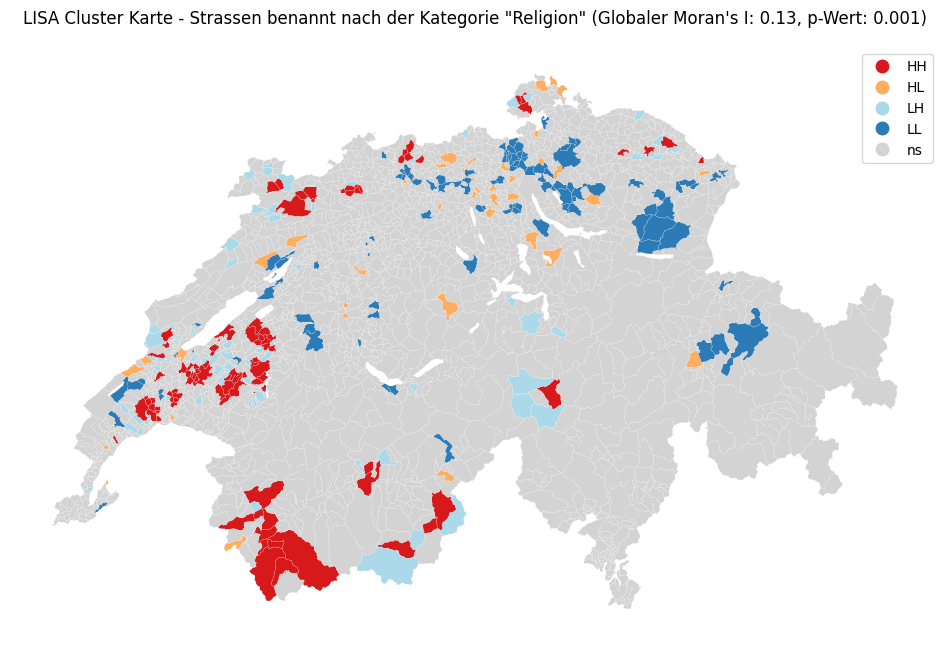

In [426]:
from splot.esda import lisa_cluster
from libpysal.weights.contiguity import Queen
from esda.moran import Moran_Local, Moran


trans = communes_kategorie.drop(columns=['geometry'])
gdf = pd.merge(com_geom, trans, on=['GMDNR'], how='outer')
gdf['percent_subset'].fillna(value=gdf['percent_subset'].mean(), inplace = True)

#gdf = gdf[gdf.classif_y > 10]


#gdf.loc[gdf['classif_y'] < 10, 'percent_subset'] = gdf['percent_subset'].mean()

#gdf = communes_kategorie
w = Queen.from_dataframe(gdf)
y = gdf['percent_subset'].values
moran = Moran(y, w)

moran_loc = Moran_Local(y, w)
lisa_cluster(moran_loc, gdf, p=0.05, figsize = (12,12))
string = "LISA Cluster Karte - Strassen benannt nach der Kategorie \"" + str(kategorie) +'\" (Globaler Moran\'s I: ' + str(round(moran.I,2)) + ', p-Wert: '+ str(round(moran.p_sim,5)) + ')'
plt.title(string)
plt.show()

Text(0.5, 0, '% Kategorie: Lebewesen')

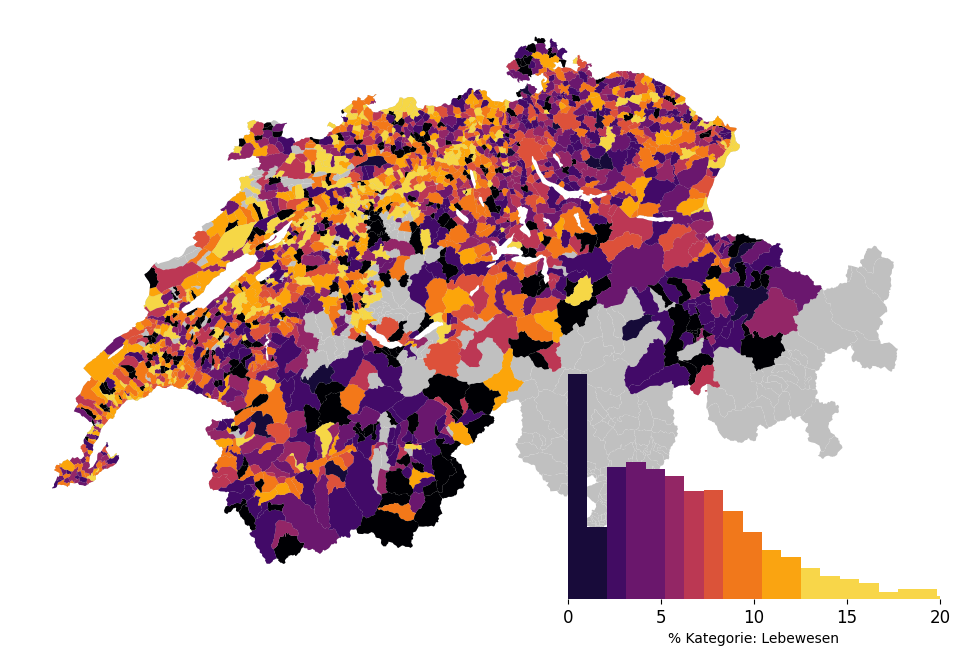

In [435]:
kategorie = 'Lebewesen'

streetnames_s = pd.read_csv('../Modeling/out_mapping.csv', encoding='UTF-8-SIG', sep=';', low_memory=False)
subset = streetnames_s['classif'].str.contains(kategorie).groupby(streetnames_s['COM_FOSNR']).sum().to_frame()
subset["classif"] = subset["classif"].astype(int)

alle = streetnames_s.groupby(['COM_FOSNR'])['classif'].agg(pd.Series.count).to_frame()

kategorie_merge = pd.merge(subset, alle, on='COM_FOSNR', how='outer')

kategorie_merge = kategorie_merge.assign(percent_subset = kategorie_merge.classif_x/kategorie_merge.classif_y*100)

communes_kategorie = pd.merge(communes_de_fr, kategorie_merge, left_on='GMDNR', right_on='COM_FOSNR', how='left')
communes_kategorie = communes_kategorie.fillna(0)
communes_kategorie = communes_kategorie[communes_kategorie.classif_y > 10]

import palettable.matplotlib as palmpl
import mapclassify as mc

k=10
bins = mc.Quantiles(communes_kategorie['percent_subset'].values, k=k).bins
bins = bins.astype(int).tolist()
bins = dict(bins=bins)
bins

f,ax = plt.subplots(1, figsize=(12,12))
communes.plot(figsize=(12,12),ax=ax, color = 'silver')
communes_kategorie.plot('percent_subset', k=k, ax=ax, cmap='inferno', scheme="User_Defined",
                             classification_kwds=bins)

bins = mc.Quantiles(communes_kategorie['percent_subset'].values, k=k).bins
ax.axis('off')

legendgram(f,ax,communes_kategorie['percent_subset'],bins,pal=palmpl.Inferno_10,
           legend_size=(.4,.4), # legend size in fractions of the axis
           loc='lower right', # matplotlib-style legend locations
           clip = (0,20) # clip the displayed range of the histogram
           )

xlabel = '% Kategorie: ' + kategorie
plt.xlabel(xlabel)

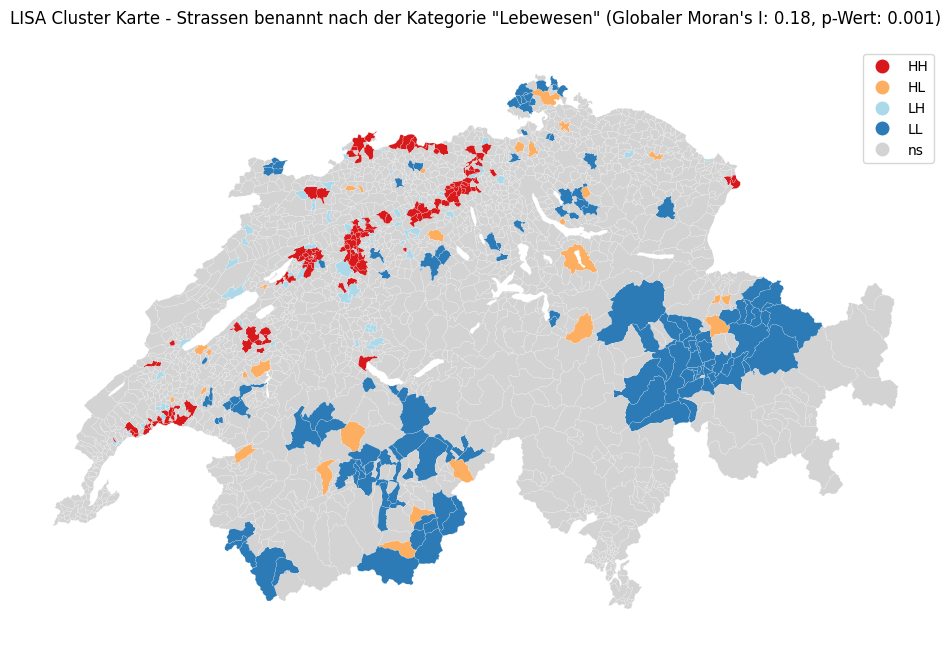

In [433]:
trans = communes_kategorie.drop(columns=['geometry'])
gdf = pd.merge(com_geom, trans, on=['GMDNR'], how='outer')
gdf['percent_subset'].fillna(value=gdf['percent_subset'].median(), inplace = True)

w = Queen.from_dataframe(gdf)
y = gdf['percent_subset'].values
moran = Moran(y, w)

moran_loc = Moran_Local(y, w)
lisa_cluster(moran_loc, gdf, p=0.05, figsize = (12,12))
string = "LISA Cluster Karte - Strassen benannt nach der Kategorie \"" + str(kategorie) +'\" (Globaler Moran\'s I: ' + str(round(moran.I,2)) + ', p-Wert: '+ str(round(moran.p_sim,5)) + ')'
plt.title(string)
plt.show()

Text(0.5, 0, '% Kategorie: Natur')

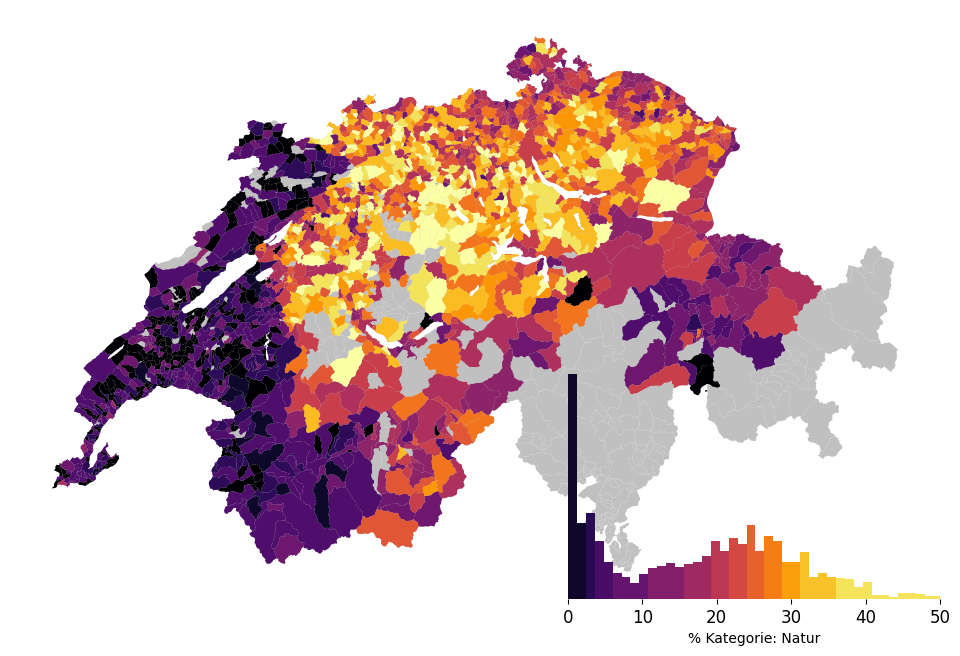

In [443]:
kategorie = 'Natur'

streetnames_s = pd.read_csv('../Modeling/out_mapping.csv', encoding='UTF-8-SIG', sep=';', low_memory=False)
subset = streetnames_s['classif'].str.contains(kategorie).groupby(streetnames_s['COM_FOSNR']).sum().to_frame()
subset["classif"] = subset["classif"].astype(int)

alle = streetnames_s.groupby(['COM_FOSNR'])['classif'].agg(pd.Series.count).to_frame()

kategorie_merge = pd.merge(subset, alle, on='COM_FOSNR', how='outer')

kategorie_merge = kategorie_merge.assign(percent_subset = kategorie_merge.classif_x/kategorie_merge.classif_y*100)

communes_kategorie = pd.merge(communes_de_fr, kategorie_merge, left_on='GMDNR', right_on='COM_FOSNR', how='left')
communes_kategorie = communes_kategorie.fillna(0)
communes_kategorie = communes_kategorie[communes_kategorie.classif_y > 10]

import palettable.matplotlib as palmpl
import mapclassify as mc

k=14
bins = mc.Quantiles(communes_kategorie['percent_subset'].values, k=k).bins
bins = bins.astype(int).tolist()
bins = dict(bins=bins)
bins

f,ax = plt.subplots(1, figsize=(12,12))
communes.plot(figsize=(12,12),ax=ax, color = 'silver')
communes_kategorie.plot('percent_subset', k=k, ax=ax, cmap='inferno', scheme="User_Defined",
                             classification_kwds=bins)

bins = mc.Quantiles(communes_kategorie['percent_subset'].values, k=k).bins
ax.axis('off')

legendgram(f,ax,communes_kategorie['percent_subset'],bins,pal=palmpl.Inferno_14,
           legend_size=(.4,.4), # legend size in fractions of the axis
           loc='lower right', # matplotlib-style legend locations
           clip = (0,50) # clip the displayed range of the histogram
           )

xlabel = '% Kategorie: ' + kategorie
plt.xlabel(xlabel)

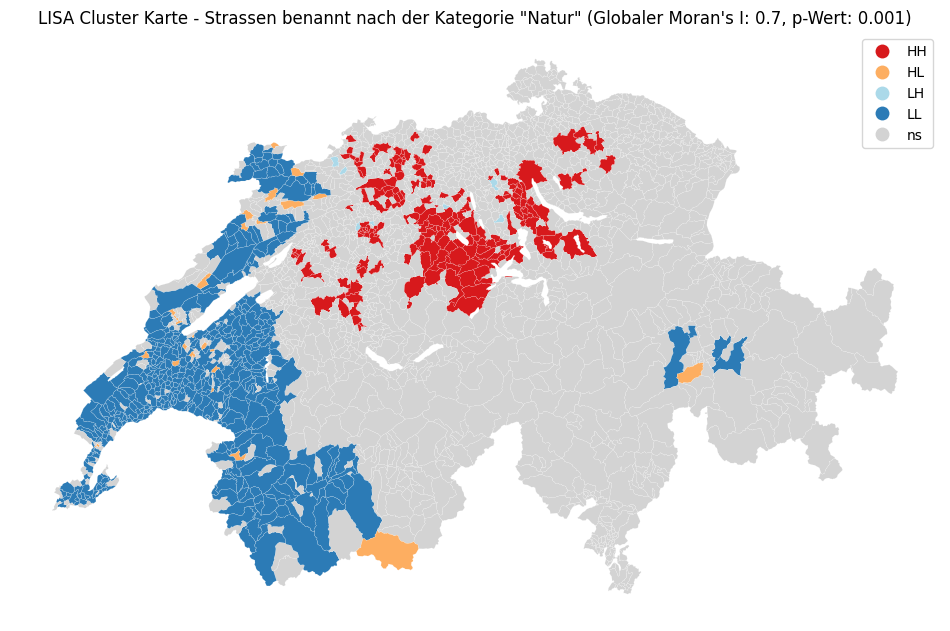

In [441]:
trans = communes_kategorie.drop(columns=['geometry'])
gdf = pd.merge(com_geom, trans, on=['GMDNR'], how='outer')
gdf['percent_subset'].fillna(value=gdf['percent_subset'].median(), inplace = True)

w = Queen.from_dataframe(gdf)
y = gdf['percent_subset'].values
moran = Moran(y, w)

moran_loc = Moran_Local(y, w)
lisa_cluster(moran_loc, gdf, p=0.01, figsize = (12,12))
string = "LISA Cluster Karte - Strassen benannt nach der Kategorie \"" + str(kategorie) +'\" (Globaler Moran\'s I: ' + str(round(moran.I,2)) + ', p-Wert: '+ str(round(moran.p_sim,5)) + ')'
plt.title(string)
plt.show()

Text(0.5, 0, '% Kategorie: Konnte nicht bestimmt werden')

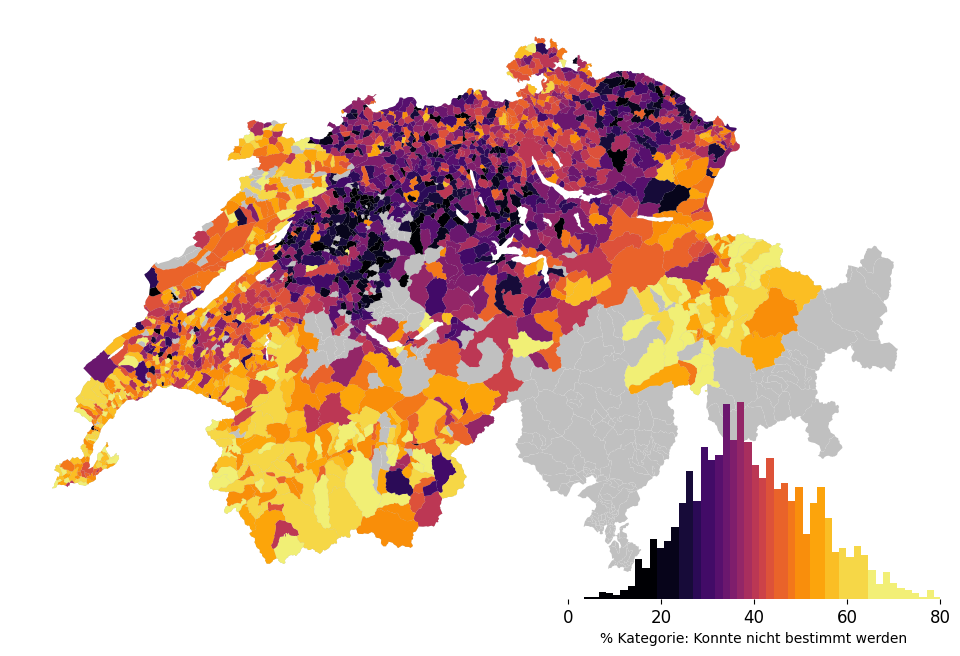

In [466]:
kategorie = 'Andere'

streetnames_s = pd.read_csv('../Modeling/out_mapping.csv', encoding='UTF-8-SIG', sep=';', low_memory=False)
subset = streetnames_s['classif'].str.contains(kategorie).groupby(streetnames_s['COM_FOSNR']).sum().to_frame()
subset["classif"] = subset["classif"].astype(int)

alle = streetnames_s.groupby(['COM_FOSNR'])['classif'].agg(pd.Series.count).to_frame()

kategorie_merge = pd.merge(subset, alle, on='COM_FOSNR', how='outer')

kategorie_merge = kategorie_merge.assign(percent_subset = kategorie_merge.classif_x/kategorie_merge.classif_y*100)

communes_kategorie = pd.merge(communes_de_fr, kategorie_merge, left_on='GMDNR', right_on='COM_FOSNR', how='left')
communes_kategorie = communes_kategorie.fillna(0)
communes_kategorie = communes_kategorie[communes_kategorie.classif_y > 10]

import palettable.matplotlib as palmpl
import mapclassify as mc

k=20
bins = mc.Quantiles(communes_kategorie['percent_subset'].values, k=k).bins
bins = bins.astype(int).tolist()
bins = dict(bins=bins)
bins

f,ax = plt.subplots(1, figsize=(12,12))
communes.plot(figsize=(12,12),ax=ax, color = 'silver')
communes_kategorie.plot('percent_subset', k=k, ax=ax, cmap='inferno', scheme="User_Defined",
                             classification_kwds=bins)

bins = mc.Quantiles(communes_kategorie['percent_subset'].values, k=k).bins
ax.axis('off')

legendgram(f,ax,communes_kategorie['percent_subset'],bins,pal=palmpl.Inferno_20,
           legend_size=(.4,.35), # legend size in fractions of the axis
           loc='lower right', # matplotlib-style legend locations
           clip = (0,80) # clip the displayed range of the histogram
           )
kategorie = 'Konnte nicht bestimmt werden'
xlabel = '% Kategorie: ' + kategorie
plt.xlabel(xlabel)

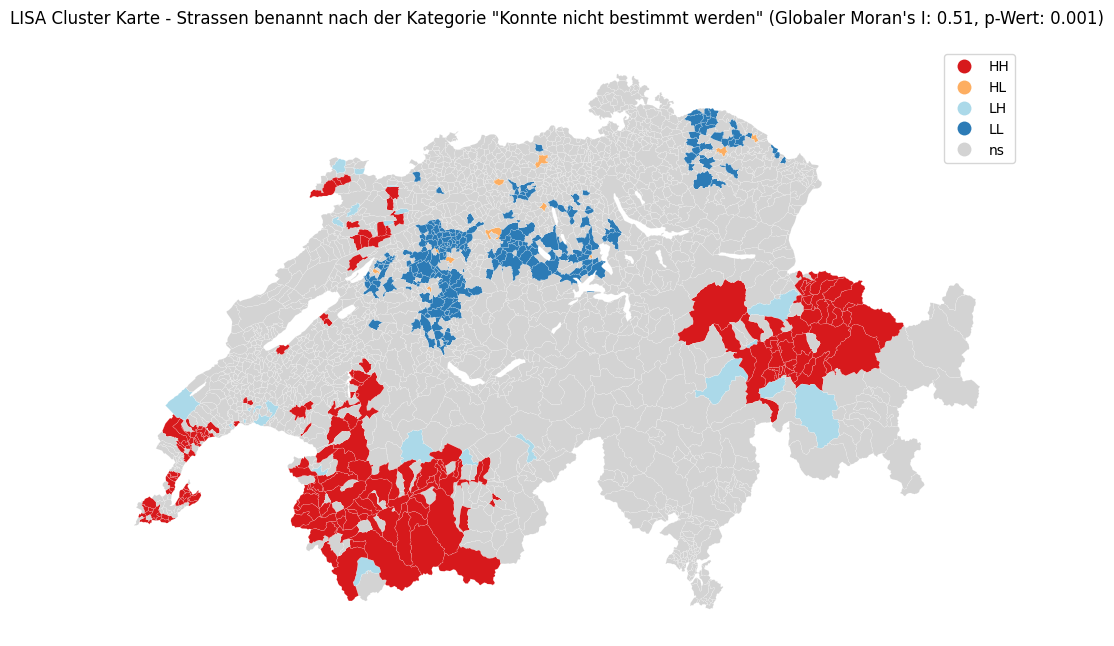

In [458]:
trans = communes_kategorie.drop(columns=['geometry'])
gdf = pd.merge(com_geom, trans, on=['GMDNR'], how='outer')
gdf['percent_subset'].fillna(value=gdf['percent_subset'].median(), inplace = True)

w = Queen.from_dataframe(gdf)
y = gdf['percent_subset'].values
moran = Moran(y, w)

moran_loc = Moran_Local(y, w)
lisa_cluster(moran_loc, gdf, p=0.01, figsize = (12,12))
string = "LISA Cluster Karte - Strassen benannt nach der Kategorie \"" + str(kategorie) +'\" (Globaler Moran\'s I: ' + str(round(moran.I,2)) + ', p-Wert: '+ str(round(moran.p_sim,5)) + ')'
plt.title(string)
plt.show()

In [375]:
print(gdf[gdf['GMDNAME'].str.contains('Glarus')])

     FID_x  GMDHISTID  GMDNR      GMDNAME  BZHISTID  BZNR  KTNR  GRNR  \
649    649      15479   1630  Glarus Nord     10109   800     8     5   
650    650      15478   1631   Glarus Süd     10109   800     8     5   
651    651      15480   1632       Glarus     10109   800     8     5   

     AREA_HA  E_MIN_x  ...  AREA_HA_y   E_CNTR_y   N_CNTR_y  Z_CNTR_y  \
649    14700  2714690  ...    14700.0  2723200.0  1217800.0     436.0   
650    43003  2709274  ...    43003.0  2724300.0  1206100.0     537.0   
651    10367  2710559  ...    10367.0  2723700.0  1211300.0     475.0   

     GMD_STR_LENGTH  STR_TERMS   classif  classif_x  classif_y  percent_subset  
649      233.574842    strasse  Siedlung       19.0      424.0        4.481132  
650      230.676557    strasse     Natur        9.0      359.0        2.506964  
651      111.984463    strasse  Siedlung        4.0      252.0        1.587302  

[3 rows x 57 columns]


https://pysal.org/scipy2019-intermediate-gds/stochastic/gds5-exploration.html

https://pysal.org/scipy2019-intermediate-gds/stochastic/gds6-spatial-clusters.html

These types of local spatial autocorrelation describe similarities or dissimilarities between a specific 
polygon with its neighboring polygons. The upper left quadrant for example indicates that polygons with low 
values are surrounded by polygons with high values (LH). The lower right quadrant shows polygons with high 
values surrounded by neighbors with low values (HL). This indicates an association of dissimilar values.

Text(0.5, 0, '% Kategorie: strasse')

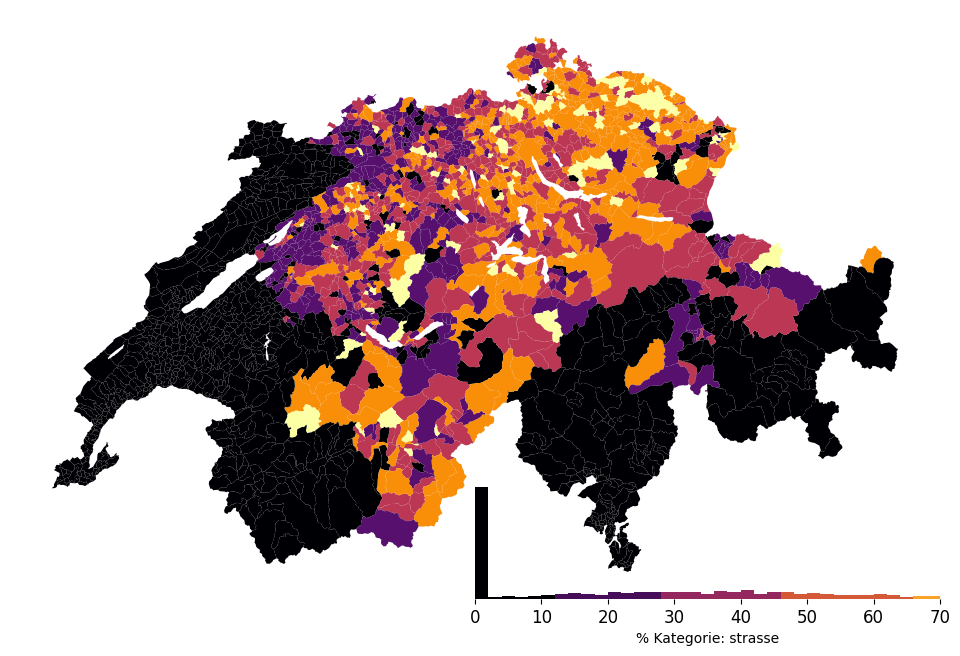

In [476]:
kategorie = 'strasse'

subset = streetnames_s['STN_LABEL_NO_BI'].str.contains(kategorie).groupby(streetnames_s['COM_FOSNR']).sum().to_frame()
subset["STN_LABEL_NO_BI"] = subset["STN_LABEL_NO_BI"].astype(int)

alle = streetnames_s.groupby(['COM_FOSNR'])['STN_LABEL_NO_BI'].agg(pd.Series.count).to_frame()

kategorie_merge = pd.merge(subset, alle, on='COM_FOSNR', how='outer')

kategorie_merge = kategorie_merge.assign(percent_subset = kategorie_merge.STN_LABEL_NO_BI_x/kategorie_merge.STN_LABEL_NO_BI_y*100)

communes_kategorie = pd.merge(communes, kategorie_merge, left_on='GMDNR', right_on='COM_FOSNR', how='outer')
communes_kategorie = communes_kategorie.fillna(0)

import palettable.matplotlib as palmpl
import mapclassify as mc

k=5
bins = mc.NaturalBreaks(communes_kategorie['percent_subset'].values, k=k).bins
bins = bins.astype(int).tolist()
bins = dict(bins=bins)
bins

f,ax = plt.subplots(1, figsize=(12,12))
communes_kategorie.plot('percent_subset', k=k, ax=ax, cmap='inferno', scheme="User_Defined",
                             classification_kwds=bins)

bins = mc.NaturalBreaks(communes_kategorie['percent_subset'].values, k=k).bins
ax.axis('off')

legendgram(f,ax,communes_kategorie['percent_subset'],bins,pal=palmpl.Inferno_5,
           legend_size=(.5,.2), # legend size in fractions of the axis
           loc='lower right', # matplotlib-style legend locations
           clip = (0,70) # clip the displayed range of the histogram
           )

xlabel = '% Kategorie: ' + kategorie
plt.xlabel(xlabel)

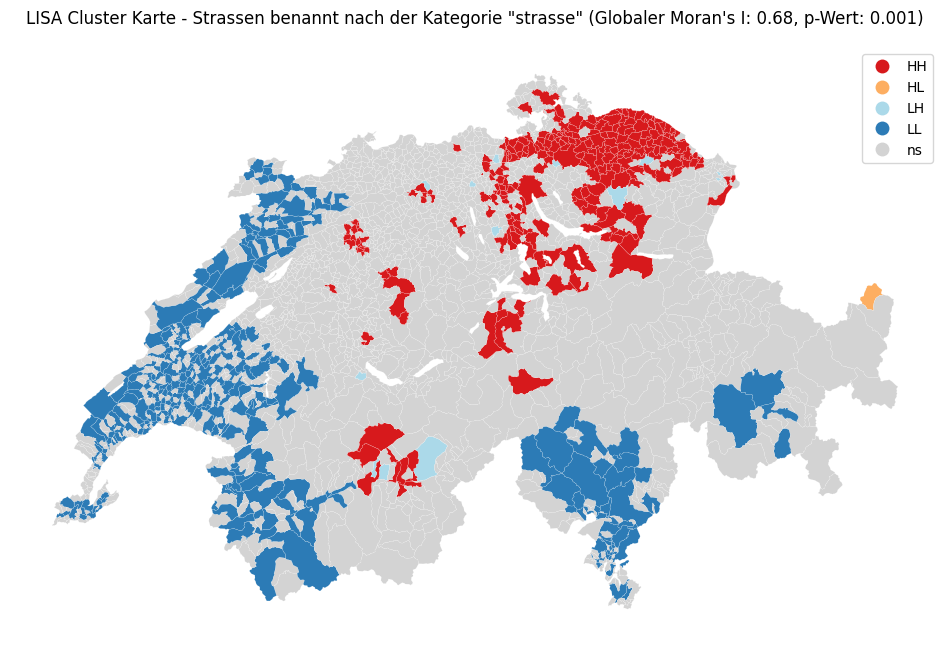

In [478]:
trans = communes_kategorie.drop(columns=['geometry'])
gdf = pd.merge(com_geom, trans, on=['GMDNR'], how='outer')
gdf['percent_subset'].fillna(value=gdf['percent_subset'].median(), inplace = True)

w = Queen.from_dataframe(gdf)
y = gdf['percent_subset'].values
moran = Moran(y, w)

moran_loc = Moran_Local(y, w)
lisa_cluster(moran_loc, gdf, p=0.01, figsize = (12,12))
string = "LISA Cluster Karte - Strassen benannt nach der Kategorie \"" + str(kategorie) +'\" (Globaler Moran\'s I: ' + str(round(moran.I,2)) + ', p-Wert: '+ str(round(moran.p_sim,5)) + ')'
plt.title(string)
plt.show()

In [62]:
print(communes_kategorie[communes_kategorie['GMDNAME_x'].str.contains('Neuchâtel')])

       FID  GMDHISTID_x  GMDNR  GMDNAME_x  BZHISTID_x  BZNR_x  KTNR_x  GRNR_x  \
2043  2043        16604   6458  Neuchâtel       10320    2400      24       2   

      AREA_HA_x    E_MIN  ...  KTNR_y  GRNR_y  AREA_HA_y  E_CNTR_y  N_CNTR_y  \
2043       3008  2554853  ...      24       2       3008   2561300   1204700   

      Z_CNTR_y  GMD_STR_LENGTH  classif_x  classif_y  percent_subset  
2043       438      187.559438       67.0      390.0       17.179487  

[1 rows x 35 columns]
